In [6]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

import random as rd
import numpy as np
import pandas as pd
from utils import LSH, plotting, SAX
from tqdm import tqdm

# CUMSUM and PAA
The focus of our investigation is on how the threshold of the cumsum filter affects the application of the Piecewise Aggregate Approximation (PAA) technique. Specifically, we are using the cumsum filter to identify the intervals within a time series where the mean will be computed.

C:\Users\adrien.cortes\AppData\Local\Temp\9\ipykernel_10868\3916197081.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(data.loc[events, 'Date'], data.loc[events, 'Close'], 'ro',color="green",label="cumsum events")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\adrien.cortes\AppData\Local\Temp\9\ipykernel_10868\3916197081.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(data.loc[events, 'Date'], data.loc[events, 'Close'], 'ro',color="green",label="cumsum events")


Text(0.5, 1.0, 'CUMSUM threshold equal to 0.1')

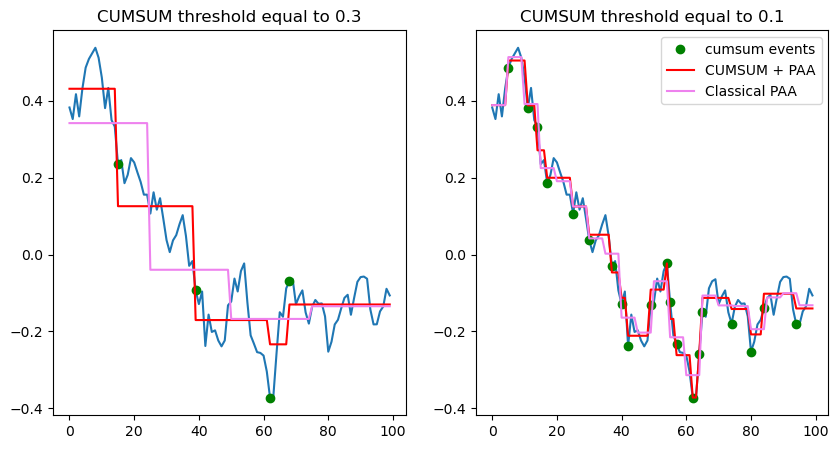

In [4]:
data = pd.DataFrame()
data["Close"] = np.cumsum(np.random.normal(0,1,100))
data["Close"] = (data["Close"]-data["Close"].mean())/np.var(data["Close"])
data["Date"] = data.index


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


data,events,events_sax = SAX.getting_approximation(data,0.3)
# Plot the time series

ax1.plot(data['Close'])
ax1.plot(data.loc[events, 'Date'], data.loc[events, 'Close'], 'ro',color="green",label="cumsum events")
ax1.plot(data["approx_CUMSUM"],color="red",label="CUMSUM + PAA")
ax1.plot(data["approx_SAX"],color="violet",label="Classical PAA")
plt.legend()
ax1.set_title('CUMSUM threshold equal to 0.3')


data,events,events_sax = SAX.getting_approximation(data,0.1)
ax2.plot(data['Close'])
ax2.plot(data.loc[events, 'Date'], data.loc[events, 'Close'], 'ro',color="green",label="cumsum events")
ax2.plot(data["approx_CUMSUM"],color="red",label="CUMSUM + PAA")
ax2.plot(data["approx_SAX"],color="violet",label="Classical PAA")
plt.legend()
ax2.set_title('CUMSUM threshold equal to 0.1')


In this study, we aim to evaluate the efficacy of our approach in comparison to the 2008 algorithm. We adopt a similar methodology, with the addition of utilizing the cumsum technique and hopping to explore potential differences in the resultant time series, up to the quantization stage. We plan to establish pairs of time series, compute their euclidean distance, and analyze the outcomes obtained by both CUMSUM and Symbolic Aggregate approXimation (SAX) techniques. By doing so, we aim to provide an empirical assessment of the performance of our proposed approach.

In [8]:
def run_stats_PAA_CUMSUM(h):
    out = pd.DataFrame()
    for i in range(3000):
    
        data1 = pd.DataFrame()
        data1["Close"] = np.cumsum(np.random.normal(0,1,100))
        data1["Close"] = (data1["Close"]-data1["Close"].mean())/np.var(data1["Close"])
        data1["Date"] = data1.index
    
        data2 = pd.DataFrame()
        data2["Close"] = np.cumsum(np.random.normal(0,1,100))
        data2["Close"] = (data2["Close"]-data2["Close"].mean())/np.var(data2["Close"])
        data2["Date"] = data2.index

        data1,events1,events_sax1 = SAX.getting_approximation(data1,h)
        data2,events2,events_sax2 = SAX.getting_approximation(data2,h)

        out.loc[i,"real_distance"] = np.sqrt(np.sum((data1["Close"]-data2["Close"])**2))
        out.loc[i,"CUMSUM_PAA_distance"] = np.sqrt(np.sum((data1["approx_CUMSUM"]-data2["approx_CUMSUM"])**2))
        out.loc[i,"PAA_distance"] = np.sqrt(np.sum((data1["approx_SAX"]-data2["approx_SAX"])**2))
        out.loc[i,"nb events CUMSUM1"] = len(events1)
        out.loc[i,"nb events SAX1"] = len(events_sax1)
    
        out.loc[i,"nb events CUMSUM2"] = len(events2)
        out.loc[i,"nb events SAX2"] = len(events_sax2)
    
    
    out = out[out["nb events CUMSUM1"] == out["nb events SAX1"]] #to be ok for comparison  same number of item 
    out = out[out["nb events CUMSUM2"] == out["nb events SAX2"]] #same number of item for projection 
    
    out["CUMSUM_PAA_distance"] = (out["CUMSUM_PAA_distance"]/out["real_distance"])
    out["PAA_distance"] = (out["PAA_distance"]/out["real_distance"])
    out = out.reset_index()
    return out 

In [9]:
stats = pd.DataFrame()
j=0
for i in tqdm([0.1,0.15,0.20,0.25]):
    
    out = run_stats_PAA_CUMSUM(i)
    stats.loc[j,"threshold"] = i
    stats.loc[j,"CUMSUM_PAA_distance_mean"] = out["CUMSUM_PAA_distance"].mean()
    stats.loc[j,"PAA_distance_mean"] = out["PAA_distance"].mean()
    stats.loc[j,"CUMSUM_PAA_distance_var"] = out["CUMSUM_PAA_distance"].var()
    stats.loc[j,"PAA_distance_var"] = out["PAA_distance"].var()
    j+=1

 75%|███████▌  | 3/4 [09:31<03:10, 190.36s/it]


ZeroDivisionError: division by zero

In [10]:
stats.columns = ['threshold', 'dist_CUM','dist_PAA','var_CUM','var_PAA']
stats

,threshold,dist_CUM,dist_PAA,var_CUM,var_PAA
0,0.10,0.992023,0.963617,0.000210,0.000886
1,0.15,0.981749,0.945279,0.001830,0.029486
2,0.20,0.981456,0.932013,0.005284,0.082607


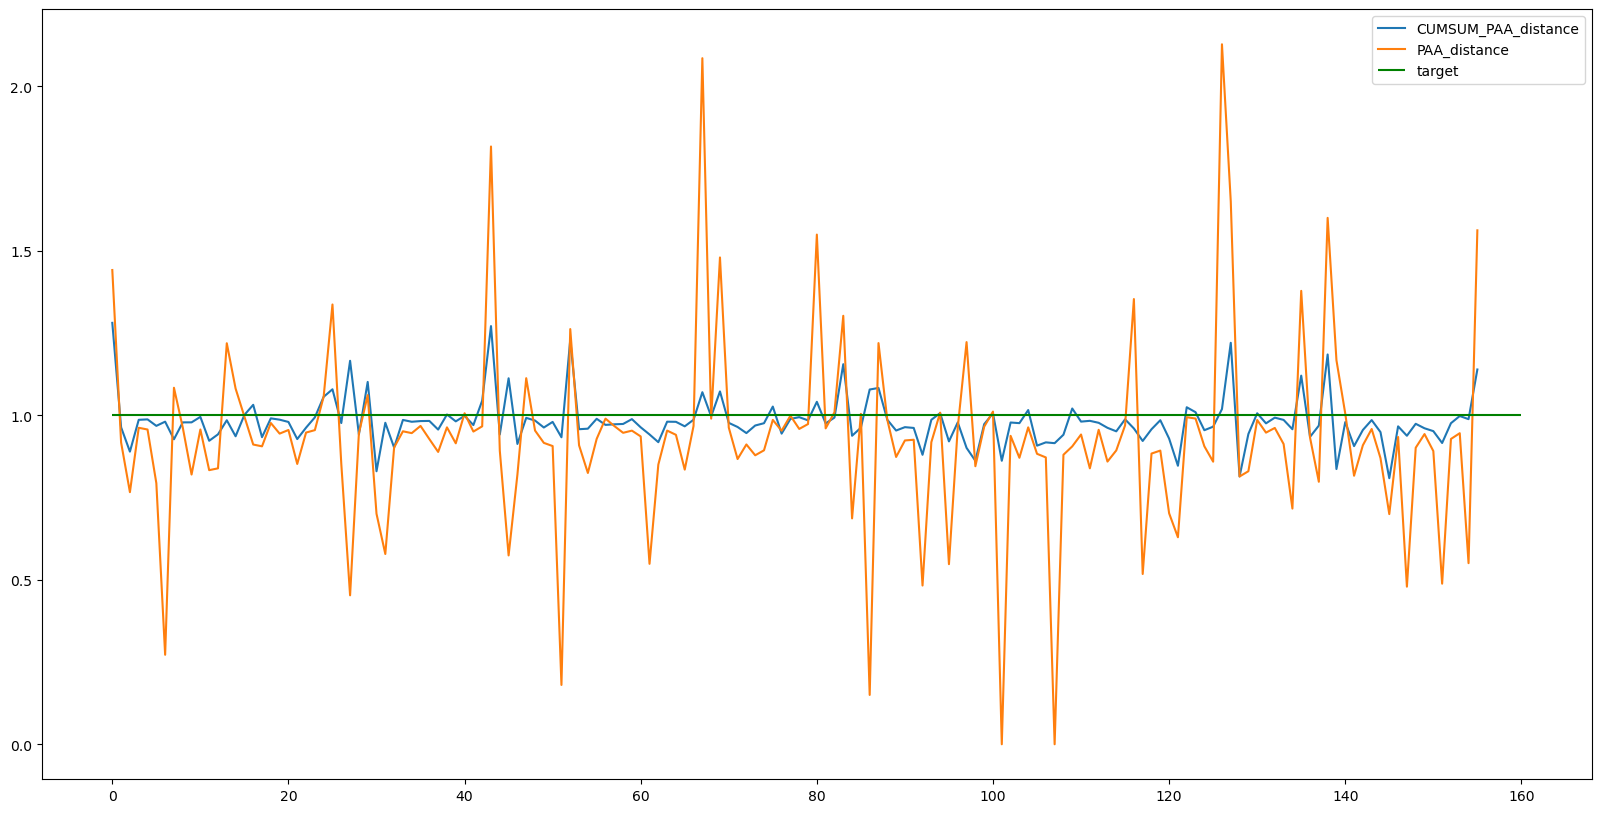

In [19]:
### out = run_stats_PAA_CUMSUM(0.24)
out[["CUMSUM_PAA_distance","PAA_distance"]].plot(figsize=(20,10)) #we overperform.. For the same number of points !
plt.hlines(y=1,xmin=0,xmax=160,color="green",label="target")
plt.legend()


# How to reconstruct the data from SAX code ? 

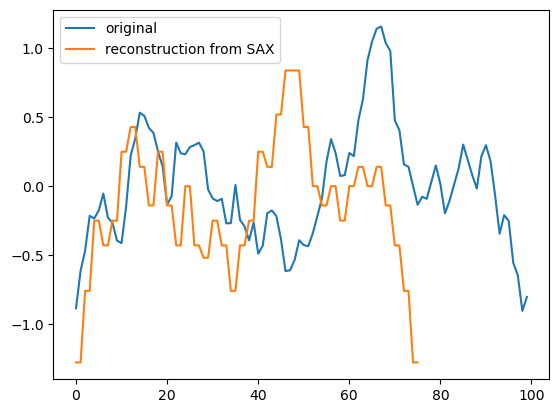

In [23]:
data1 = pd.DataFrame()
data1["Close"] = np.cumsum(np.random.normal(0,1,100))
data1["Close"] = (data1["Close"]-data1["Close"].mean())/np.var(data1["Close"])
data1["Date"] = data1.index
#getting_SAX_notation(data1,0.2) #100 points résumés en 11 ici 

data1 = pd.DataFrame()
data1["Close"] = np.cumsum(np.random.normal(0,1,100))
data1["Close"] = (data1["Close"]-data1["Close"].mean())/np.var(data1["Close"])
data1["Date"] = data1.index

data1["Close"].plot(label="original")
plt.plot(SAX.from_SAX_to_data(SAX.getting_SAX_notation(data1,0.2)[0]),label="reconstruction from SAX")
plt.legend()